In [ ]:
import os
import cv2
import seaborn as sns
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn import datasets, preprocessing, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_fscore_support

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = "/content/drive/MyDrive/CSE428/Project/Group_5/train"
test_path = "/content/drive/MyDrive/CSE428/Project/Group_5/test"

In [ ]:
import os

class_counts = {}

for class_name in os.listdir(train_path):
  class_path = os.path.join(train_path, class_name)
  if os.path.isdir(class_path):
    num_images = len(os.listdir(class_path))
    class_counts[class_name] = num_images

for class_name in os.listdir(test_path):
  class_path = os.path.join(test_path, class_name)
  if os.path.isdir(class_path):
    num_images = len(os.listdir(class_path))
    class_counts[class_name] += num_images

total_images = 0
for class_name, count in class_counts.items():
  print(f"Class {class_name}: {count} images")
  total_images += count
print(f"\nTotal Images: {total_images}")

Class projectile: 550 images
Class reel: 300 images
Class pill-bottle: 550 images
Class fence: 550 images
Class snail: 450 images

Total Images: 2400


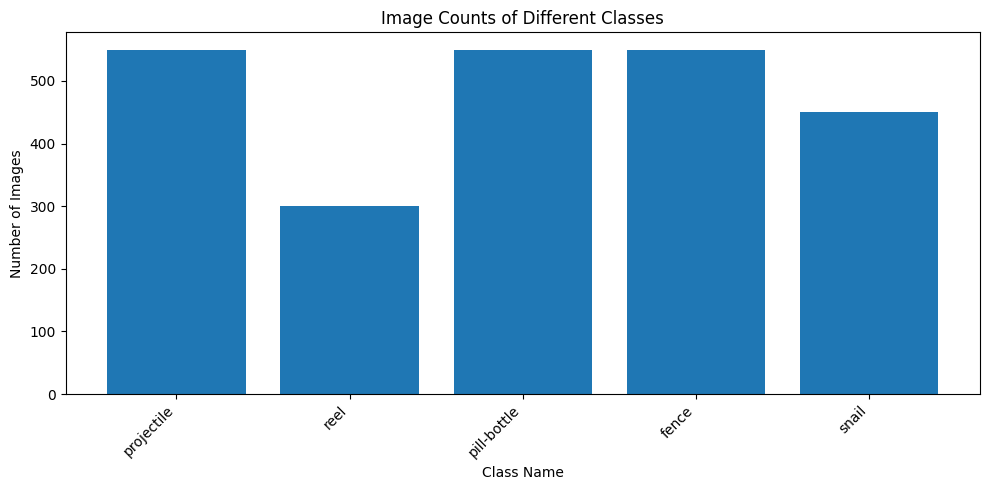

In [ ]:
class_names = list(class_counts.keys())
image_counts = list(class_counts.values())

plt.figure(figsize=(10, 5))
plt.bar(class_names, image_counts)
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.title('Image Counts of Different Classes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
counts = list(class_counts.values())
if all(count == counts[0] for count in counts):
  print("The dataset is balanced.")
else:
  print("The dataset is not balanced.")

The dataset is not balanced.


In [ ]:
class_names = []

# Tasks


## Logistic Regression

In [ ]:
def load_data(main_folder_path):
    X = [] #store the image data
    y = [] #store the class labels
    class_folders = sorted(os.listdir(main_folder_path))

    for class_idx, class_folder in tqdm(enumerate(class_folders), total=len(class_folders), desc="Loading Classes"):
        class_folder_path = os.path.join(main_folder_path, class_folder)
        if class_folder not in class_names:
          class_names.append(class_folder)

        images = os.listdir(class_folder_path)
        for image_name in images:
            image_path = os.path.join(class_folder_path, image_name)
            image = load_img(image_path, target_size=(64, 64))
            image = img_to_array(image) / 255.0 # Normalize to [0,1]
            X.append(image)
            y.append(class_idx)

    return np.array(X), np.array(y)

In [ ]:
def sharpen_image(image):
    sharpening_kernel = np.array([[-1,-1,-1],
                                  [-1, 9,-1],
                                  [-1,-1,-1]])
    sharpened = cv2.filter2D(image, -1, sharpening_kernel)
    sharpened_clipped = np.clip(sharpened, 0, 1) # Clip values to the range [0, 1]
    return sharpened_clipped

In [ ]:
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(10,7))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
X_train, y_train = load_data(train_path)
X_test, y_test = load_data(test_path)

Loading Classes:   0%|          | 0/5 [00:00<?, ?it/s]

Loading Classes:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
for label, class_name in enumerate(class_names):
    print(f"Class Name: {class_name} - Label: {label}")

Class Name: fence - Label: 0
Class Name: pill-bottle - Label: 1
Class Name: projectile - Label: 2
Class Name: reel - Label: 3
Class Name: snail - Label: 4


In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2150, 64, 64, 3) (2150,)
(250, 64, 64, 3) (250,)


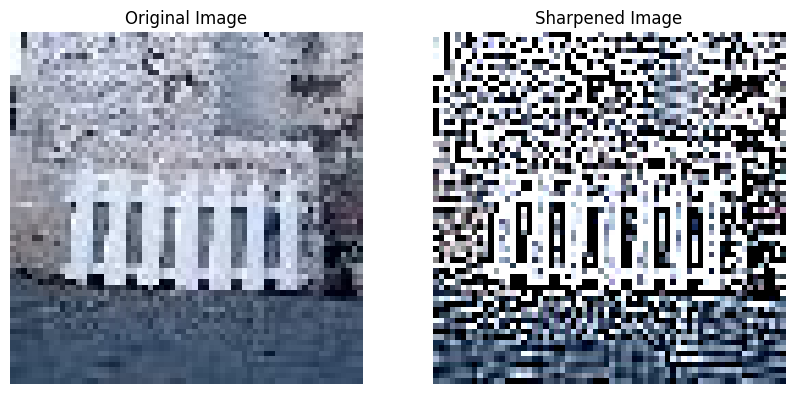

In [ ]:
image_idx = 200

original_image = X_train[image_idx]
sharpened_image = sharpen_image(original_image)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sharpened_image)
plt.title('Sharpened Image')
plt.axis('off')

plt.show()

In [ ]:
X_train = np.array([sharpen_image(img) for img in X_train])
X_test = np.array([sharpen_image(img) for img in X_test])

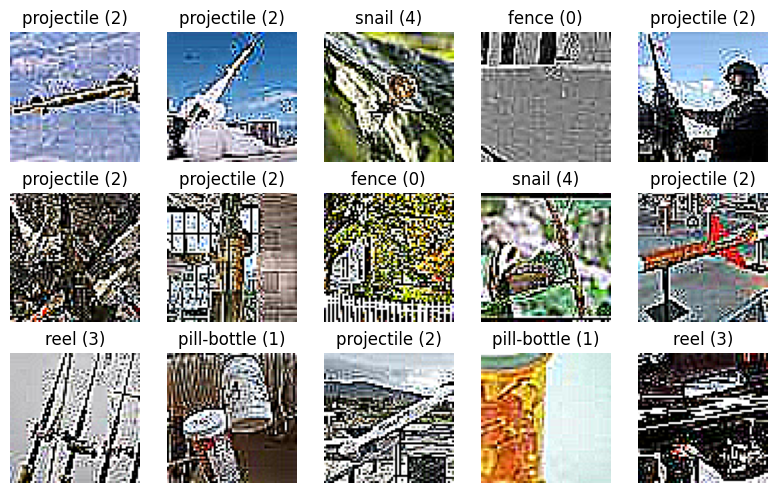

In [ ]:
random_indices = random.sample(range(X_train.shape[0]), 15)

fig, axes = plt.subplots(3, 5, figsize=(8, 5))
for idx, ax in zip(random_indices, axes.flatten()):
    image = X_train[idx].reshape(64, 64, 3)
    label = y_train[idx]
    class_name = class_names[label]
    ax.imshow(image)
    ax.set_title(f"{class_name} ({label})")
    ax.axis('off')

plt.tight_layout()
plt.show()

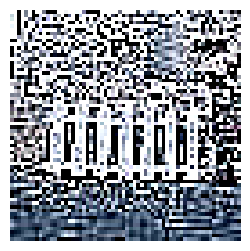

In [ ]:
idx = 200

flattened_image = np.reshape(X_train[idx], (1, -1, 3))

plt.figure(figsize=(150, 50))
plt.imshow(flattened_image)
plt.axis('off')
plt.show()

print()

plt.figure(figsize=(3, 3))
plt.imshow(np.reshape(X_train[idx], (64, 64, 3)))
plt.axis('off')
plt.show()

In [ ]:
x_train = X_train.reshape(X_train.shape[0], -1)
x_test = X_test.reshape(X_test.shape[0], -1)

In [ ]:
# x_train = preprocessing.minmax_scale(x_train)
# x_test = preprocessing.minmax_scale(x_test)

In [ ]:
model = linear_model.LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=2000)
model = model.fit(x_train, y_train)

Accuracy: 0.316
Sensitivity (per class): [0.24, 0.46, 0.44, 0.08, 0.36]
Specificity (per class): [0.825, 0.75, 0.745, 0.98, 0.845]
Positive Predictive Value (PPV) (per class): [0.2553191489361702, 0.3150684931506849, 0.3013698630136986, 0.5, 0.3673469387755102]
Negative Predictive Value (NPV) (per class): [0.812807881773399, 0.847457627118644, 0.8418079096045198, 0.8099173553719008, 0.8407960199004975]
F1 Score: 0.29613947912093286


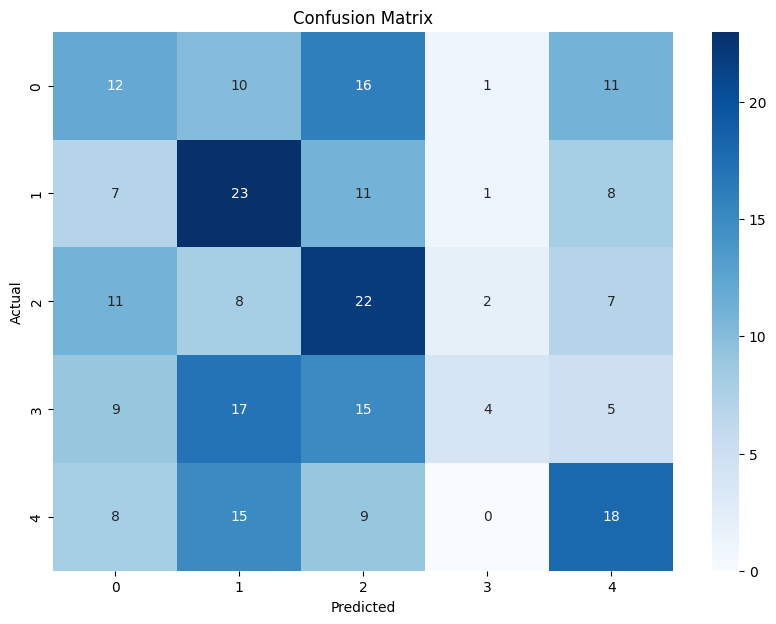

In [ ]:
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')

    # Calculate sensitivity, specificity, PPV, and NPV for each class
    sensitivity, specificity, PPV, NPV = [], [], [], []
    for i in range(len(conf_matrix)):
        TP = conf_matrix[i, i]
        FN = conf_matrix[i, :].sum() - TP
        FP = conf_matrix[:, i].sum() - TP
        TN = conf_matrix.sum() - (TP + FN + FP)

        sensitivity.append(TP / (TP + FN) if (TP + FN) != 0 else 0)
        specificity.append(TN / (TN + FP) if (TN + FP) != 0 else 0)
        PPV.append(TP / (TP + FP) if (TP + FP) != 0 else 0)
        NPV.append(TN / (TN + FN) if (TN + FN) != 0 else 0)

    print("Accuracy:", accuracy)
    print("Sensitivity (per class):", sensitivity)
    print("Specificity (per class):", specificity)
    print("Positive Predictive Value (PPV) (per class):", PPV)
    print("Negative Predictive Value (NPV) (per class):", NPV)
    print("F1 Score:", f1)

    plot_confusion_matrix(conf_matrix)

evaluate_model(model, x_test, y_test)

# NN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import to_categorical, plot_model

In [ ]:
print("shape of X =", x_train.shape)
print("shape of y =", y_train.shape)

shape of X = (2150, 12288)
shape of y = (2150,)


In [ ]:
print("shape of X =", x_test.shape)
print("shape of y =", y_test.shape)

shape of X = (250, 12288)
shape of y = (250,)


In [ ]:
number_of_classes = len(class_names)
y_train_one_hot = to_categorical(y_train, num_classes=number_of_classes)
y_test_one_hot = to_categorical(y_test, num_classes=number_of_classes)

In [ ]:
y_train_one_hot.shape

(2150, 5)

In [ ]:
x_train.shape[1]

12288

In [ ]:
model = Sequential([
    Dense(256, input_dim=x_train.shape[1], activation='sigmoid'),
    Dense(128, activation='sigmoid'),
    Dense(64, activation='sigmoid'),
    Dense(32, activation='sigmoid'),
    Dense(number_of_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x_train, y_train_one_hot, epochs=60, batch_size=128)

Epoch 1/60
17/17 [==============================] - 2s 133ms/step - loss: 0.2595 - accuracy: 0.9628
Epoch 2/60
17/17 [==============================] - 3s 189ms/step - loss: 0.2533 - accuracy: 0.9637
Epoch 3/60
17/17 [==============================] - 3s 155ms/step - loss: 0.2468 - accuracy: 0.9623
Epoch 4/60
17/17 [==============================] - 2s 125ms/step - loss: 0.2450 - accuracy: 0.9647
Epoch 5/60
17/17 [==============================] - 2s 118ms/step - loss: 0.3460 - accuracy: 0.9153
Epoch 6/60
17/17 [==============================] - 1s 68ms/step - loss: 1.1851 - accuracy: 0.5795
Epoch 7/60
17/17 [==============================] - 1s 68ms/step - loss: 1.0845 - accuracy: 0.5716
Epoch 8/60
17/17 [==============================] - 1s 68ms/step - loss: 0.7576 - accuracy: 0.6763
Epoch 9/60
17/17 [==============================] - 1s 68ms/step - loss: 0.6629 - accuracy: 0.7326
Epoch 10/60
17/17 [==============================] - 1s 80ms/step - loss: 0.6039 - accuracy: 0.7772
Epoc

8/8 [==============================] - 0s 9ms/step
Accuracy: 0.348
Sensitivity (per class): [0.34, 0.44, 0.36, 0.34, 0.26]
Specificity (per class): [0.78, 0.835, 0.895, 0.78, 0.895]
Positive Predictive Value (PPV) (per class): [0.2786885245901639, 0.4, 0.46153846153846156, 0.2786885245901639, 0.38235294117647056]
Negative Predictive Value (NPV) (per class): [0.8253968253968254, 0.8564102564102564, 0.8483412322274881, 0.8253968253968254, 0.8287037037037037]
Confusion Matrix:
 [[17  6  8 12  7]
 [ 9 22  3 10  6]
 [13  5 18 10  4]
 [12 11  6 17  4]
 [10 11  4 12 13]]
F1 Score: 0.3491356846413026


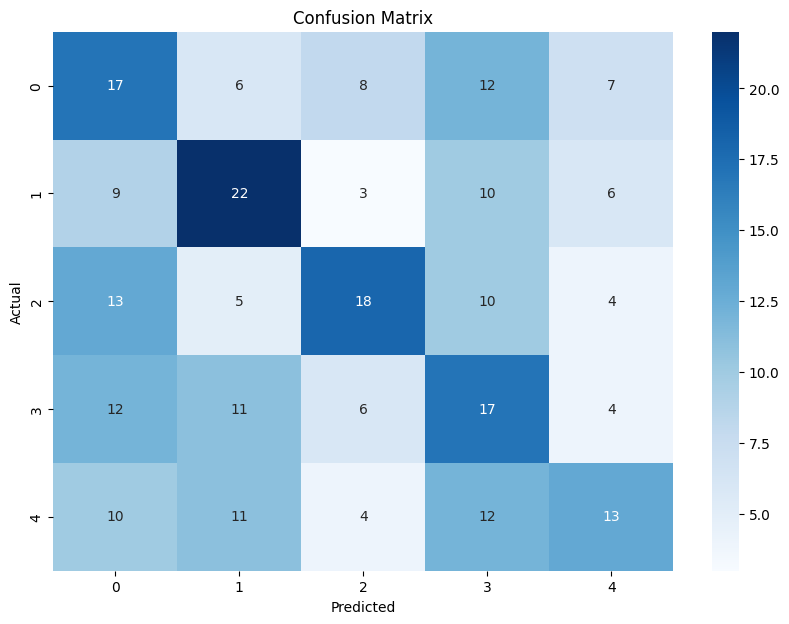

In [ ]:
def evaluate_model(model, X, y):
    y_pred = np.argmax(model.predict(X), axis=-1)
    accuracy = accuracy_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')

    sensitivity, specificity, PPV, NPV = [], [], [], []
    for i in range(len(conf_matrix)):
        TP = conf_matrix[i, i]
        FN = conf_matrix[i, :].sum() - TP
        FP = conf_matrix[:, i].sum() - TP
        TN = conf_matrix.sum() - (TP + FN + FP)

        sensitivity.append(TP / (TP + FN) if (TP + FN) != 0 else 0)
        specificity.append(TN / (TN + FP) if (TN + FP) != 0 else 0)
        PPV.append(TP / (TP + FP) if (TP + FP) != 0 else 0)
        NPV.append(TN / (TN + FN) if (TN + FN) != 0 else 0)

    print("Accuracy:", accuracy)
    print("Sensitivity (per class):", sensitivity)
    print("Specificity (per class):", specificity)
    print("Positive Predictive Value (PPV) (per class):", PPV)
    print("Negative Predictive Value (NPV) (per class):", NPV)
    print("F1 Score:", f1)

    plot_confusion_matrix(conf_matrix)

evaluate_model(model, x_test, y_test)